---
# **Machine Learning For Virginia: Predictive Analysis of Stock Market Prices**

 ### **Authors: Eric Nguyen, Hieu Vu, Kevin Zhao**
-  wvu9cs, brr2tu, twq8db
- Any questions regarding this report should be directed to these authors

### Summary:
- Exploratory Data Analysis & Data Cleaning
- Decision Tree Model (Baseline)
- Long Short Term Memory (LSTM) Model - No Fine Tuning
- LSTM - Fine Tuned
- LSTM - Fine Tuned with Different Timeframe
- Analysis and Conclusion


---
## 1. Big Picure and Setup, Exploratory Data Analysis
In this section, we fetch our datasets and load them into dataframes in Python. In addition, we check any missing values, the size, and column types. We also visualize the correlations between variables.

---


In [ ]:
# Import necessary packages for this project
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

# Use Yahoo Finance to fetch data for Virginia Big Tech Companies
yf.pdr_override()
apple = pdr.get_data_yahoo('AAPL', start=datetime(2015, 1, 1), end=datetime(2019, 10, 31))
amazon = pdr.get_data_yahoo('AMZN', start=datetime(2015, 1, 1), end=datetime(2019, 10, 31))
cisco = pdr.get_data_yahoo('CSCO', start=datetime(2015, 1, 1), end=datetime(2019, 10, 31))
google = pdr.get_data_yahoo('GOOG', start=datetime(2015, 1, 1), end=datetime(2019, 10, 31))
microsoft = pdr.get_data_yahoo('MSFT', start=datetime(2015, 1, 1), end=datetime(2019, 10, 31))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Import necessary packages for this project
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys


# Defining helper functions
def get_size(df, name):
    size = sys.getsizeof(df) / (1024 * 1024)  # Calculate the size of the DataFrame in MB
    print(f"Size of {name} dataset is: {size} MB")

def get_entries_features(df):
  num_entries, num_features = df.shape
  print(f"Number of entries: {num_entries}")
  print(f"Number of features: {num_features}")

def check_categorical(df):
  categorical_features = df.select_dtypes(include=['object']).columns.tolist()
  print(f"Categorical features: {len(categorical_features)}")

def check_na(df):
  missing_values = df.isna().sum().sum()
  print(f"Total missing values: {missing_values}")

def basic_stats(df):
  basic_stats = df.describe()
  print("Basic statistics of the dataset:\n")
  print(basic_stats)

In [ ]:
# Exploratory Data Analysis on each company
companies = [
    "apple", "amazon", "cisco", "google", "microsoft"
]

company_dataframes = [
    apple, amazon, cisco, google, microsoft
]

stock_abbreviations = [
    'AAPL', 'AMZN', 'CSCO', 'GOOG', 'MSFT'
]


for company, company_dataframe in zip(companies, company_dataframes):
  print()
  print("-----------------")
  print(f'Statistics for {company.capitalize()}')
  get_size(company_dataframe, company)
  get_entries_features(company_dataframe)
  check_categorical(company_dataframe)
  check_na(company_dataframe)
  basic_stats(company_dataframe)



-----------------
Statistics for Apple
Size of apple dataset is: 0.0649566650390625 MB
Number of entries: 1216
Number of features: 6
Categorical features: 0
Total missing values: 0
Basic statistics of the dataset:

              Open         High          Low        Close    Adj Close  \
count  1216.000000  1216.000000  1216.000000  1216.000000  1216.000000   
mean     37.616686    37.949700    37.289274    37.628559    35.392786   
std       9.800493     9.896854     9.719888     9.808320     9.974281   
min      22.500000    22.917500    22.367500    22.584999    20.798660   
25%      28.793126    29.059375    28.485625    28.786250    26.283261   
50%      36.548750    36.867500    36.278749    36.638750    34.329493   
75%      44.821874    45.138124    44.452499    44.750626    42.953356   
max      62.242500    62.437500    61.680000    62.262501    60.476559   

             Volume  
count  1.216000e+03  
mean   1.450058e+08  
std    7.202495e+07  
min    4.544800e+07  
25%    

In [ ]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# This helper function will prepare our training and test sets
def process(df, start_year, end_year):
    # Convert the index to datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Filter the data based on the date
    train_df = df[df.index.year <= start_year]
    test_df = df[df.index.year >= end_year]

    # Separate the features and the target variable 'Close'
    X_train = train_df.drop("Close", axis=1)
    y_train = train_df["Close"]
    X_test = test_df.drop("Close", axis=1)
    y_test = test_df["Close"]

    # Define the numerical attributes (assuming all are numerical except 'Close')
    num_attribs = X_train.select_dtypes(include=[np.number]).columns.tolist()

    # Create a pipeline for numerical attributes
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

    # Create a full pipeline for the data
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

    # Apply the full pipeline to the training and test sets
    X_train_prepared = full_pipeline.fit_transform(X_train)
    X_test_prepared = full_pipeline.transform(X_test)

    return X_train_prepared, X_test_prepared, y_train, y_test



---
## 2. Baseline Regression Testing

In this section, we use a Decision Tree Regressor to establish baseline results using a model we have learned in class and output the results as RMSE scores. We use a K-fold cross validator to reduce overfitting and ensuring results are precise and accurate.

We also implement a baseline LSTM model which is the model we will be focusing on and comparing against the Decision Tree Regression.


---

In [ ]:
# Dictionary to store the models and their RMSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

models_rmse = {}

for company, company_dataframe in zip(companies, company_dataframes):
    train_prepared, test_prepared, y_train, y_test = process(company_dataframe, 2018, 2019)
    exec(f"{company}_train_prepared = train_prepared")
    exec(f"{company}_test_prepared = test_prepared")
    exec(f"{company}_y_train = y_train")
    exec(f"{company}_y_test = y_test")

    # Create a DecisionTreeRegressor for the current company
    tree_reg = DecisionTreeRegressor(max_depth=15, min_samples_leaf=65, random_state=42)
    tree_reg.fit(eval(f"{company}_train_prepared"), eval(f"{company}_y_train"))

    # Predict using the trained model
    company_predictions = tree_reg.predict(eval(f"{company}_test_prepared"))

    # Calculate RMSE
    company_mse = mean_squared_error(eval(f"{company}_y_test"), company_predictions)
    company_rmse = np.sqrt(company_mse)

    # Store the model and its RMSE in the dictionary
    models_rmse[stock_abbreviations[companies.index(company)]] = {
        'model': tree_reg,
        'rmse': company_rmse
    }

print("Results:")
for abbreviation, values in models_rmse.items():
    print(f"{abbreviation} RMSE: {values['rmse']}")


Results:
AAPL RMSE: 3.1475611247744917
AMZN RMSE: 5.065592180264843
CSCO RMSE: 5.965522104001644
GOOG RMSE: 1.6030278119947665
MSFT RMSE: 20.581284116569957


---
## 3. LSTM Testing

In this section, we use a LSTM to establish prediction results using a model we have learned in class and output the results as RMSE scores. We tune hyperparameters in order to refine our results as well as use a different time frame. Here are the models:
- LSTM (no fine tuning)
- LSTM (Fine Tuned)
- LSTM (Fine Tuned with Different Timeframe)

We implement a baseline LSTM model to demonstrate the progress we accomplished through fine tuning.


---

In [ ]:
# Baseline LSTM Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

models_rmse = {}

for company, company_dataframe in zip(companies, company_dataframes):
    train_prepared, test_prepared, y_train, y_test = process(company_dataframe, 2018, 2019)

    n_features = train_prepared.shape[1]
    train_prepared = train_prepared.reshape((train_prepared.shape[0], 1, n_features))
    test_prepared = test_prepared.reshape((test_prepared.shape[0], 1, n_features))


    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_prepared.shape[1], train_prepared.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    model.fit(train_prepared, y_train, epochs=10, batch_size=144, validation_data=(test_prepared, y_test), verbose=2, shuffle=False)

    # Predict using the trained model
    company_predictions = model.predict(test_prepared)

    # Calculate RMSE
    company_mse = mean_squared_error(y_test, company_predictions)
    company_rmse = np.sqrt(company_mse)

    # Store the model and its RMSE in the dictionary
    stock_abbreviation = stock_abbreviations[companies.index(company)]
    models_rmse[stock_abbreviation] = {
        'model': model,
        'rmse': company_rmse
    }

# Access the RMSE for a specific company using its abbreviation
print("\nResults: ")
for abbreviation, values in models_rmse.items():
    print(f"{abbreviation} RMSE: {values['rmse']}")



Epoch 1/10
7/7 - 4s - loss: 1318.6989 - val_loss: 2425.2546 - 4s/epoch - 510ms/step
Epoch 2/10
7/7 - 0s - loss: 1315.8474 - val_loss: 2420.3245 - 52ms/epoch - 7ms/step
Epoch 3/10
7/7 - 0s - loss: 1313.5878 - val_loss: 2414.6594 - 46ms/epoch - 7ms/step
Epoch 4/10
7/7 - 0s - loss: 1311.3154 - val_loss: 2408.6201 - 48ms/epoch - 7ms/step
Epoch 5/10
7/7 - 0s - loss: 1308.9825 - val_loss: 2402.2500 - 58ms/epoch - 8ms/step
Epoch 6/10
7/7 - 0s - loss: 1306.5598 - val_loss: 2395.5146 - 51ms/epoch - 7ms/step
Epoch 7/10
7/7 - 0s - loss: 1304.0209 - val_loss: 2388.3542 - 49ms/epoch - 7ms/step
Epoch 8/10
7/7 - 0s - loss: 1301.3416 - val_loss: 2380.7029 - 50ms/epoch - 7ms/step
Epoch 9/10
7/7 - 0s - loss: 1298.4990 - val_loss: 2372.4944 - 55ms/epoch - 8ms/step
Epoch 10/10
7/7 - 0s - loss: 1295.4716 - val_loss: 2363.6667 - 50ms/epoch - 7ms/step
7/7 [==============================] - 0s 2ms/step
Epoch 1/10
7/7 - 2s - loss: 2758.8359 - val_loss: 8040.2549 - 2s/epoch - 344ms/step
Epoch 2/10
7/7 - 0s - lo

In [ ]:
# LSTM - Tuning the Hyperparameters for improvement
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

def build_model(n_lstm_units=50, n_layers=1, learning_rate=0.001):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(LSTM(n_lstm_units, return_sequences=(n_layers > 1), input_shape=(None, n_features)))
        else:
            model.add(LSTM(n_lstm_units, return_sequences=(i < n_layers - 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

lstm_units = [20, 50]  # Number of LSTM units
num_layers = [1, 2]         # Number of layers
learning_rates = [0.01]  # Learning rates
batch_sizes = [32, 64]     # Batch sizes
epochs = [30]      # Number of epochs

best_params = {}
models_rmse = {}


for company, company_dataframe in zip(companies, company_dataframes):
    print(f"Training for {company.upper()}")

    best_rmse = float('inf')
    best_model = None

    train_prepared, test_prepared, y_train, y_test = process(company_dataframe, 2018, 2019)
    n_features = train_prepared.shape[1]
    train_prepared = train_prepared.reshape((train_prepared.shape[0], 1, n_features))
    test_prepared = test_prepared.reshape((test_prepared.shape[0], 1, n_features))

    for units in lstm_units:
        for layers in num_layers:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for epoch in epochs:
                        model = build_model(n_lstm_units=units, n_layers=layers, learning_rate=lr)
                        model.fit(train_prepared, y_train, epochs=epoch, batch_size=batch_size,
                                  validation_data=(test_prepared, y_test), verbose=2, shuffle=False)


                        predictions = model.predict(test_prepared)
                        rmse = np.sqrt(mean_squared_error(y_test, predictions))


                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_model = model
                            best_params[company] = {'units': units, 'layers': layers, 'learning_rate': lr,
                                                    'batch_size': batch_size, 'epochs': epoch, 'predictions': predictions,
                                                    "actual": y_test}

    models_rmse[company] = {'model': best_model, 'rmse': best_rmse}

for company in companies:
    print(f"\n{company.upper()}")
    print(f"Best RMSE: {models_rmse[company]['rmse']}")


Training for APPLE
Epoch 1/30
32/32 - 2s - loss: 1300.6265 - val_loss: 2409.1553 - 2s/epoch - 77ms/step
Epoch 2/30
32/32 - 0s - loss: 1180.0398 - val_loss: 2322.4146 - 123ms/epoch - 4ms/step
Epoch 3/30
32/32 - 0s - loss: 1030.6205 - val_loss: 2227.1697 - 120ms/epoch - 4ms/step
Epoch 4/30
32/32 - 0s - loss: 887.2635 - val_loss: 2127.9094 - 118ms/epoch - 4ms/step
Epoch 5/30
32/32 - 0s - loss: 752.5325 - val_loss: 1928.2174 - 119ms/epoch - 4ms/step
Epoch 6/30
32/32 - 0s - loss: 603.5015 - val_loss: 1633.1512 - 117ms/epoch - 4ms/step
Epoch 7/30
32/32 - 0s - loss: 430.0603 - val_loss: 1194.2786 - 116ms/epoch - 4ms/step
Epoch 8/30
32/32 - 0s - loss: 272.0723 - val_loss: 804.8522 - 124ms/epoch - 4ms/step
Epoch 9/30
32/32 - 0s - loss: 123.4245 - val_loss: 353.7222 - 118ms/epoch - 4ms/step
Epoch 10/30
32/32 - 0s - loss: 38.7793 - val_loss: 138.7659 - 121ms/epoch - 4ms/step
Epoch 11/30
32/32 - 0s - loss: 20.2813 - val_loss: 92.9448 - 117ms/epoch - 4ms/step
Epoch 12/30
32/32 - 0s - loss: 14.6465 

In [ ]:
# Printing Predicted results vs Actual Results for all companies
for company in companies:
  print(best_params[company]['predictions'])
  print(best_params[company]['actual'])

[[39.33298 ]
 [36.003036]
 [36.89679 ]
 [37.261677]
 [37.85193 ]
 [38.32258 ]
 [38.447033]
 [38.307407]
 [37.84132 ]
 [38.144493]
 [38.750443]
 [38.96794 ]
 [39.42354 ]
 [38.82119 ]
 [38.492603]
 [38.42189 ]
 [39.288822]
 [38.964687]
 [39.160717]
 [40.843243]
 [41.794872]
 [41.850086]
 [42.448257]
 [43.681984]
 [43.661205]
 [43.091373]
 [42.30508 ]
 [42.320713]
 [42.446507]
 [42.585922]
 [42.396233]
 [42.616905]
 [42.29629 ]
 [42.984756]
 [42.438084]
 [42.762005]
 [43.523342]
 [43.15134 ]
 [43.614666]
 [43.572994]
 [43.631027]
 [44.116165]
 [43.655922]
 [43.49016 ]
 [43.26738 ]
 [42.792046]
 [44.708656]
 [45.77591 ]
 [46.11384 ]
 [46.22922 ]
 [47.391132]
 [47.433258]
 [47.76968 ]
 [47.683876]
 [49.469242]
 [49.720882]
 [48.643414]
 [48.402344]
 [47.98257 ]
 [47.59099 ]
 [48.029293]
 [48.562077]
 [48.871964]
 [49.40344 ]
 [49.245636]
 [49.621124]
 [50.421165]
 [51.142887]
 [50.496956]
 [50.488827]
 [50.539566]
 [50.110638]
 [50.697536]
 [51.11993 ]
 [51.360813]
 [51.206223]
 [51.752247]

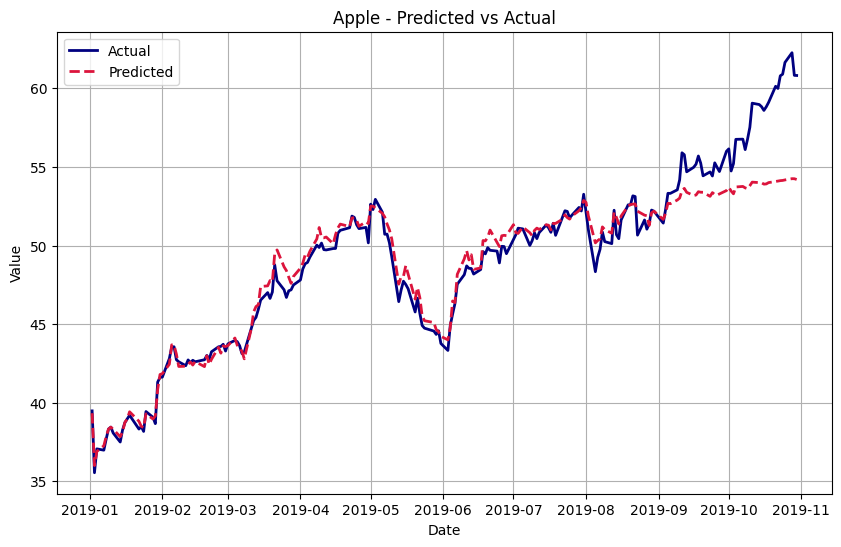

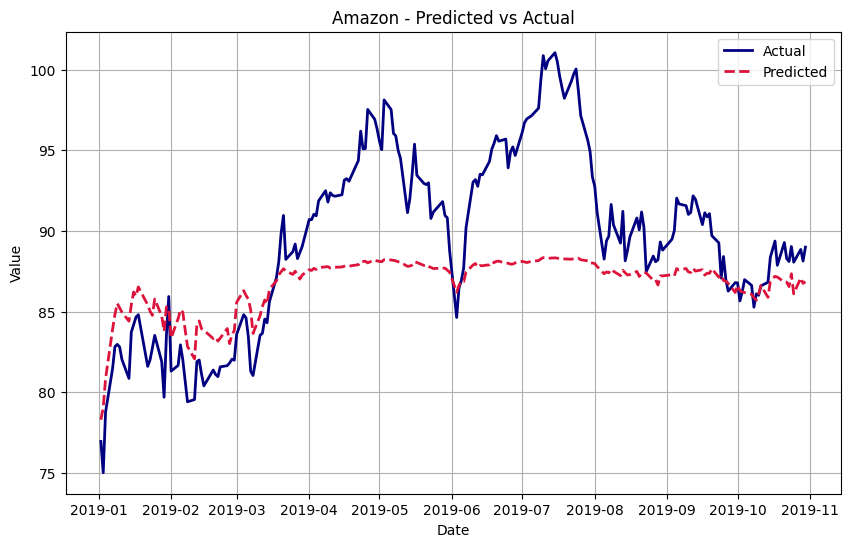

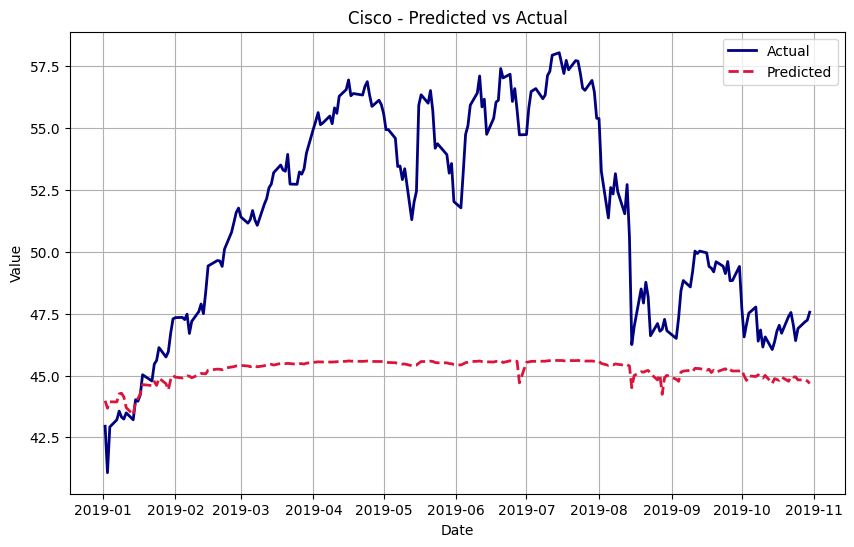

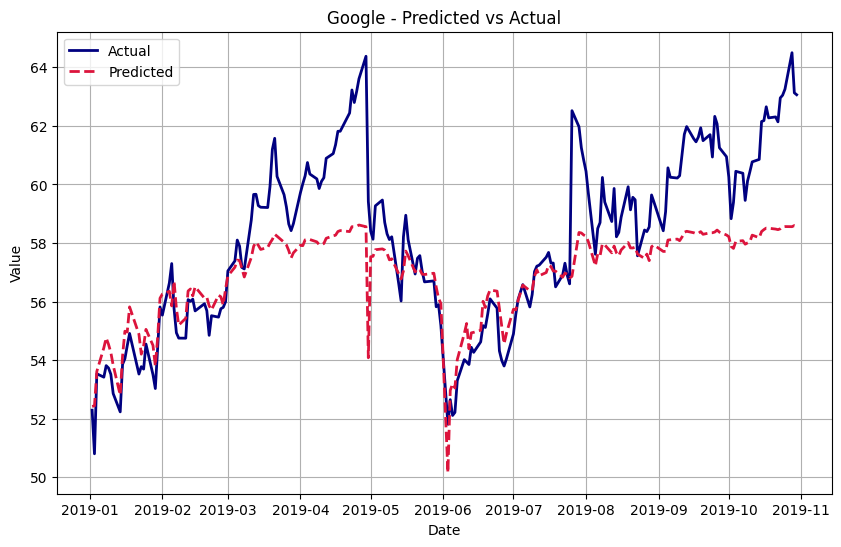

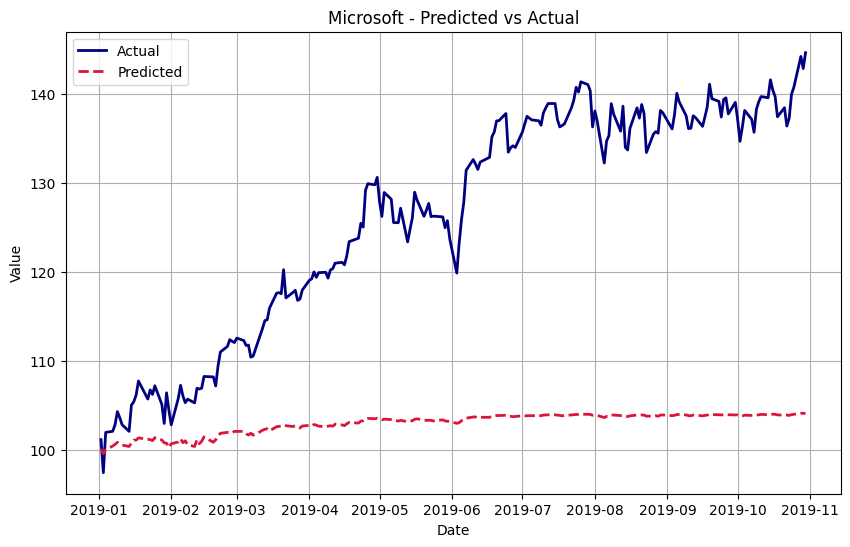

In [ ]:
# Graphing Predicted vs Actual Results for all companies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


dates = pd.date_range('2022-01-01', periods=100)

for company in companies:
    actual_dates = pd.to_datetime(best_params[company]['actual'].index)
    predicted_array = best_params[company]['predictions'].flatten()

    comparison_df = pd.DataFrame({
        'Actual': best_params[company]['actual'].values,
        'Predicted': predicted_array
    }, index=actual_dates)

    comparison_df.sort_index(inplace=True)

    # Plot the sorted actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='navy', linewidth=2)
    plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='crimson', linestyle='--', linewidth=2)
    plt.title(f'{company.capitalize()} - Predicted vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
# Retrieving new datasets with a different timeframe
yf.pdr_override()
apple = pdr.get_data_yahoo('AAPL', start=datetime(1990, 1, 1), end=datetime(2010, 10, 31))
amazon = pdr.get_data_yahoo('AMZN', start=datetime(1990, 1, 1), end=datetime(2010, 10, 31))
cisco = pdr.get_data_yahoo('CSCO', start=datetime(1990, 1, 1), end=datetime(2010, 10, 31))
google = pdr.get_data_yahoo('GOOG', start=datetime(1990, 1, 1), end=datetime(2010, 10, 31))
microsoft = pdr.get_data_yahoo('MSFT', start=datetime(1990, 1, 1), end=datetime(2010, 10, 31))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Exploratory Data Analysis on each company
companies = [
    "apple", "amazon", "cisco", "google", "microsoft"
]

company_dataframes = [
    apple, amazon, cisco, google, microsoft
]

stock_abbreviations = [
    'AAPL', 'AMZN', 'CSCO', 'GOOG', 'MSFT'
]

In [ ]:
# LSTM - Testing a new timeframe
lstm_units = [20, 50]  # Number of LSTM units
num_layers = [1, 2]         # Number of layers
learning_rates = [0.01]  # Learning rates
batch_sizes = [32, 64]     # Batch sizes
epochs = [30]      # Number of epochs

best_params = {}
models_rmse = {}


for company, company_dataframe in zip(companies, company_dataframes):
    print(f"Training for {company.upper()}")

    best_rmse = float('inf')
    best_model = None

    train_prepared, test_prepared, y_train, y_test = process(company_dataframe, 2005, 2006)
    n_features = train_prepared.shape[1]
    train_prepared = train_prepared.reshape((train_prepared.shape[0], 1, n_features))
    test_prepared = test_prepared.reshape((test_prepared.shape[0], 1, n_features))

    for units in lstm_units:
        for layers in num_layers:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for epoch in epochs:
                        model = build_model(n_lstm_units=units, n_layers=layers, learning_rate=lr)
                        model.fit(train_prepared, y_train, epochs=epoch, batch_size=batch_size,
                                  validation_data=(test_prepared, y_test), verbose=2, shuffle=False)


                        predictions = model.predict(test_prepared)
                        rmse = np.sqrt(mean_squared_error(y_test, predictions))


                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_model = model
                            best_params[company] = {'units': units, 'layers': layers, 'learning_rate': lr,
                                                    'batch_size': batch_size, 'epochs': epoch, 'predictions': predictions,
                                                    "actual": y_test}

    models_rmse[company] = {'model': best_model, 'rmse': best_rmse}

for company in companies:
    print(f"\n{company.upper()}")
    print(f"Best RMSE: {models_rmse[company]['rmse']}")


Training for APPLE
Epoch 1/30
127/127 - 3s - loss: 0.0206 - val_loss: 10.7213 - 3s/epoch - 20ms/step
Epoch 2/30
127/127 - 0s - loss: 0.0190 - val_loss: 11.1306 - 424ms/epoch - 3ms/step
Epoch 3/30
127/127 - 0s - loss: 0.1442 - val_loss: 19.4465 - 421ms/epoch - 3ms/step
Epoch 4/30
127/127 - 0s - loss: 0.0742 - val_loss: 16.8153 - 415ms/epoch - 3ms/step
Epoch 5/30
127/127 - 0s - loss: 0.0501 - val_loss: 15.8065 - 418ms/epoch - 3ms/step
Epoch 6/30
127/127 - 0s - loss: 0.0337 - val_loss: 15.2036 - 418ms/epoch - 3ms/step
Epoch 7/30
127/127 - 0s - loss: 0.0378 - val_loss: 14.7894 - 417ms/epoch - 3ms/step
Epoch 8/30
127/127 - 0s - loss: 0.0366 - val_loss: 14.5754 - 418ms/epoch - 3ms/step
Epoch 9/30
127/127 - 0s - loss: 0.0159 - val_loss: 13.9089 - 420ms/epoch - 3ms/step
Epoch 10/30
127/127 - 0s - loss: 0.0047 - val_loss: 13.1014 - 415ms/epoch - 3ms/step
Epoch 11/30
127/127 - 0s - loss: 0.0050 - val_loss: 12.3505 - 424ms/epoch - 3ms/step
Epoch 12/30
127/127 - 0s - loss: 0.0023 - val_loss: 11.88

In [ ]:
# Printing Predicted results vs Actual Results for all companies with the new timeframe
for company in companies:
  print(best_params[company]['predictions'])
  print(best_params[company]['actual'])

[[2.464798 ]
 [2.5497367]
 [2.5507927]
 ...
 [3.4081445]
 [3.4081473]
 [3.408104 ]]
Date
2006-01-03     2.669643
2006-01-04     2.677500
2006-01-05     2.656429
2006-01-06     2.725000
2006-01-09     2.716071
                ...    
2010-10-25    11.030000
2010-10-26    11.001786
2010-10-27    10.993929
2010-10-28    10.901429
2010-10-29    10.749286
Name: Close, Length: 1216, dtype: float64
[[2.3682485]
 [2.3647957]
 [2.3809884]
 ...
 [6.485934 ]
 [6.4726076]
 [6.461853 ]]
Date
2006-01-03    2.3790
2006-01-04    2.3625
2006-01-05    2.3825
2006-01-06    2.3935
2006-01-09    2.3540
               ...  
2010-10-25    8.4500
2010-10-26    8.4975
2010-10-27    8.3755
2010-10-28    8.3420
2010-10-29    8.2615
Name: Close, Length: 1216, dtype: float64
[[17.628326]
 [17.819304]
 [18.095095]
 ...
 [23.601648]
 [23.674286]
 [23.295696]]
Date
2006-01-03    17.450001
2006-01-04    17.850000
2006-01-05    18.350000
2006-01-06    18.770000
2006-01-09    19.059999
                ...    
2010-10-25

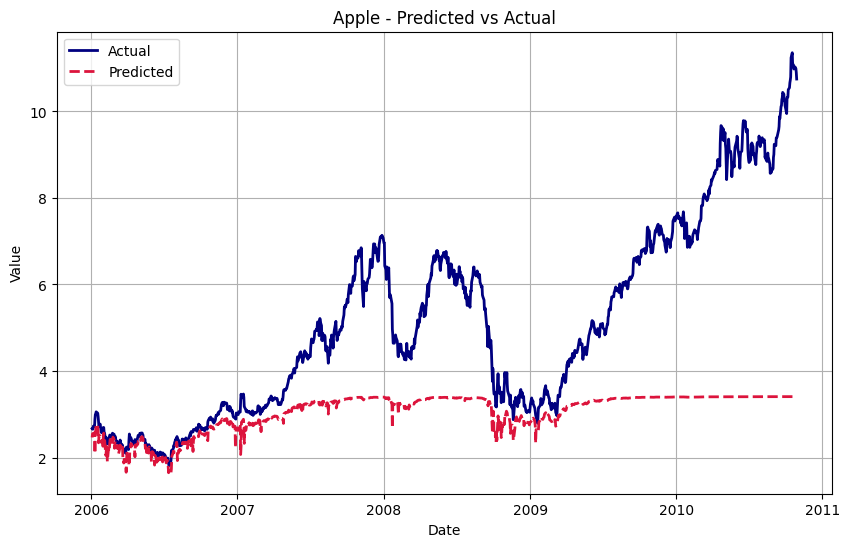

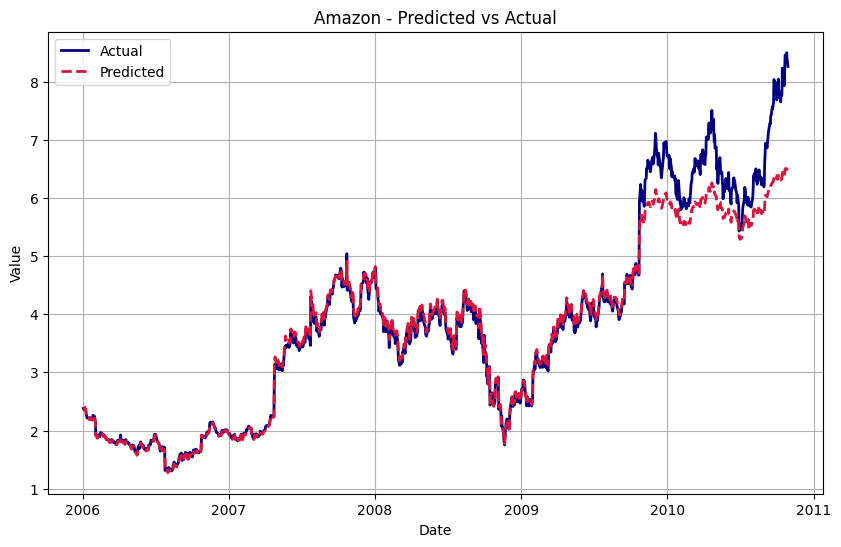

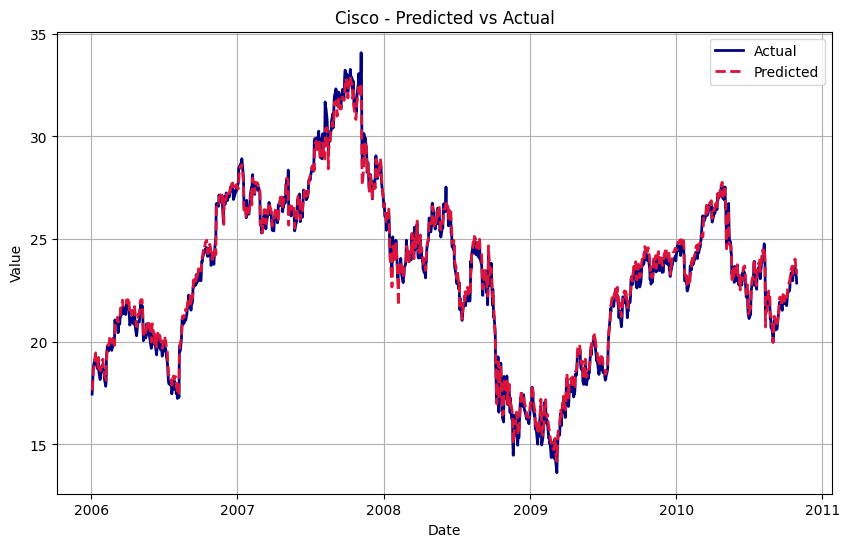

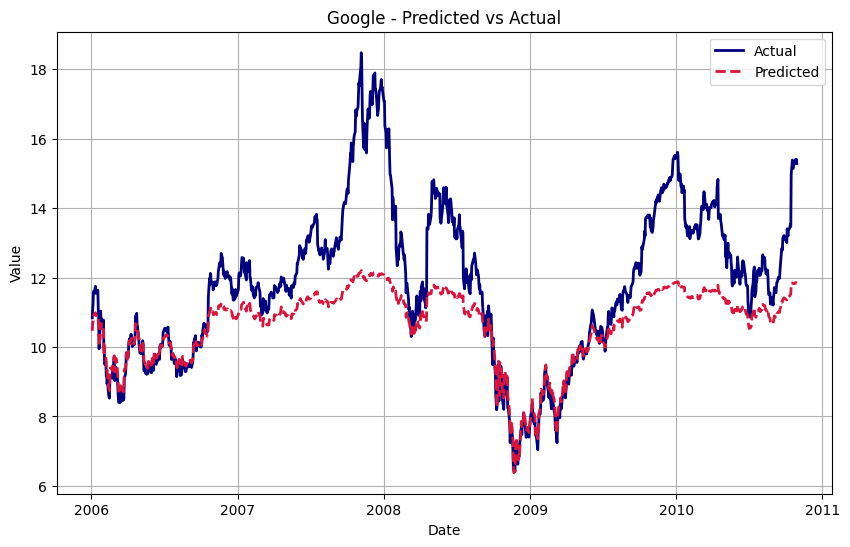

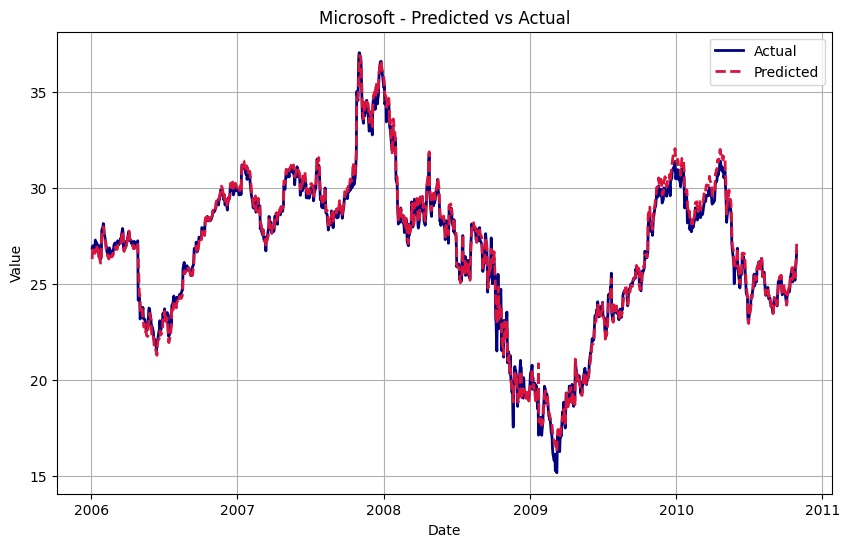

In [ ]:
# Graphing Predicted vs Actual Results for all companies for the new timeframe
dates = pd.date_range('2022-01-01', periods=100)

for company in companies:
    actual_dates = pd.to_datetime(best_params[company]['actual'].index)
    predicted_array = best_params[company]['predictions'].flatten()

    comparison_df = pd.DataFrame({
        'Actual': best_params[company]['actual'].values,
        'Predicted': predicted_array
    }, index=actual_dates)

    comparison_df.sort_index(inplace=True)

    # Plot the sorted actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='navy', linewidth=2)
    plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='crimson', linestyle='--', linewidth=2)
    plt.title(f'{company.capitalize()} - Predicted vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Stock Price Prediction Models Analysis

## Decision Tree Model
The Decision Tree model serves as the baseline in this analysis, providing relatively stable results with RMSE values ranging from 1.60 to 20.58. Notably, Microsoft (MSFT) stock predictions appear challenging, indicated by the highest RMSE value.

## LSTM Model without Fine Tuning
The LSTM model without fine-tuning yields higher RMSE values compared to the Decision Tree model. Performance varies across stocks, with Amazon (AMZN) and Microsoft (MSFT) exhibiting particularly high RMSE values. The model lacks the precision observed in the Decision Tree model. This is due to it not being fine tuned, which we address in the later models below.

## LSTM Model with Fine Tuning
Introducing fine-tuning to the LSTM model leads to substantial improvements in prediction accuracy. The best RMSE values for each stock are notably lower than those of the untuned LSTM model, demonstrating the effectiveness of fine-tuning. Despite improvements, Microsoft (MSFT) continues to be a challenging stock for the model.

## LSTM Model with Fine Tuning and Different Timeframe
The LSTM model with fine-tuning and a different timeframe demonstrates the best performance. For most stocks, this model achieves the lowest RMSE values, surpassing both the Decision Tree baseline and other LSTM models. The choice of a different timeframe seems to have a positive impact on prediction accuracy, addressing challenges posed by the original timeframe, possibly influenced by the volatility associated with the COVID-19 pandemic.

## General Observations
The progressively refined LSTM models highlight the importance of fine-tuning and selecting an appropriate timeframe in improving predictive accuracy. The success of the LSTM model with fine-tuning and a different timeframe suggests that careful preprocessing and tuning can significantly enhance the performance of deep learning models for stock price prediction. The impact of external factors, such as the COVID-19 pandemic, on stock price volatility is evident in the contrast between the original and modified timeframes.

## Conclusion
The findings emphasize the need for a nuanced approach, considering the characteristics of individual stocks and external factors that may influence their behavior. Future work could involve further exploration of different hyperparameters, model architectures, and additional feature engineering to continue improving predictive capabilities. LSTM seem to be the preferred choice for predicting stock market prices.


# References:
* CS 4774: Office Hours
* CS 4774: Lecture Materials (for LSTM)
* [PDR Documentation](https://pandas-datareader.readthedocs.io/en/latest/)
* [PDF get_data_yahoo](https://pandas-datareader.readthedocs.io/en/latest/)